In [58]:
import math
import typing as tp
from pathlib import Path
import numpy as np
from PIL import Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

root_dir = Path("../data/raw")

sns.set(style="whitegrid")

/opt/miniconda3/envs/ml/lib/python3.12/site-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.3)
  from scipy.stats import gaussian_kde


In [44]:
def load_image_paths(root_dir: Path) -> pd.DataFrame:
    """
    Recursively collect all image file paths and map them to their class label.
    """
    records: tp.List[tp.Dict[str, tp.Any]] = []

    for split_dir in sorted(root_dir.iterdir()):
        if not split_dir.is_dir():
            continue
        split_name = split_dir.name  # e.g., train, valid, test

        for class_dir in sorted(split_dir.iterdir()):
            if not class_dir.is_dir():
                continue
            class_name = class_dir.name
            images = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.JPG")) + list(class_dir.glob("*.png"))
            for img_path in images:
                records.append({"split": split_name, "class": class_name, "path": img_path})

    df = pd.DataFrame(records)
    return df


def display_image(img_path: Path, title: tp.Optional[str] = None, figsize: tp.Tuple[int, int] = (5, 5)) -> None:
    """
    Display a single image with optional title.
    """
    try:
        with Image.open(img_path) as img:
            plt.figure(figsize=figsize)
            plt.imshow(img)
            plt.axis("off")
            if title is None:
                title = img_path.parent.name
            plt.title(title)
            plt.show()
    except Exception as e:
        print(f"Failed to open {img_path}: {e}")

In [39]:
df = load_image_paths(root_dir)
df.tail(5)

split             class  \
87895  valid  Tomato___healthy   
87896  valid  Tomato___healthy   
87897  valid  Tomato___healthy   
87898  valid  Tomato___healthy   
87899  valid  Tomato___healthy   

                                                    path  
87895  ../data/raw/valid/Tomato___healthy/84d5645b-61...  
87896  ../data/raw/valid/Tomato___healthy/5216e02b-89...  
87897  ../data/raw/valid/Tomato___healthy/3e6c73ad-cf...  
87898  ../data/raw/valid/Tomato___healthy/e2bd556e-fe...  
87899  ../data/raw/valid/Tomato___healthy/a37f028b-6c...

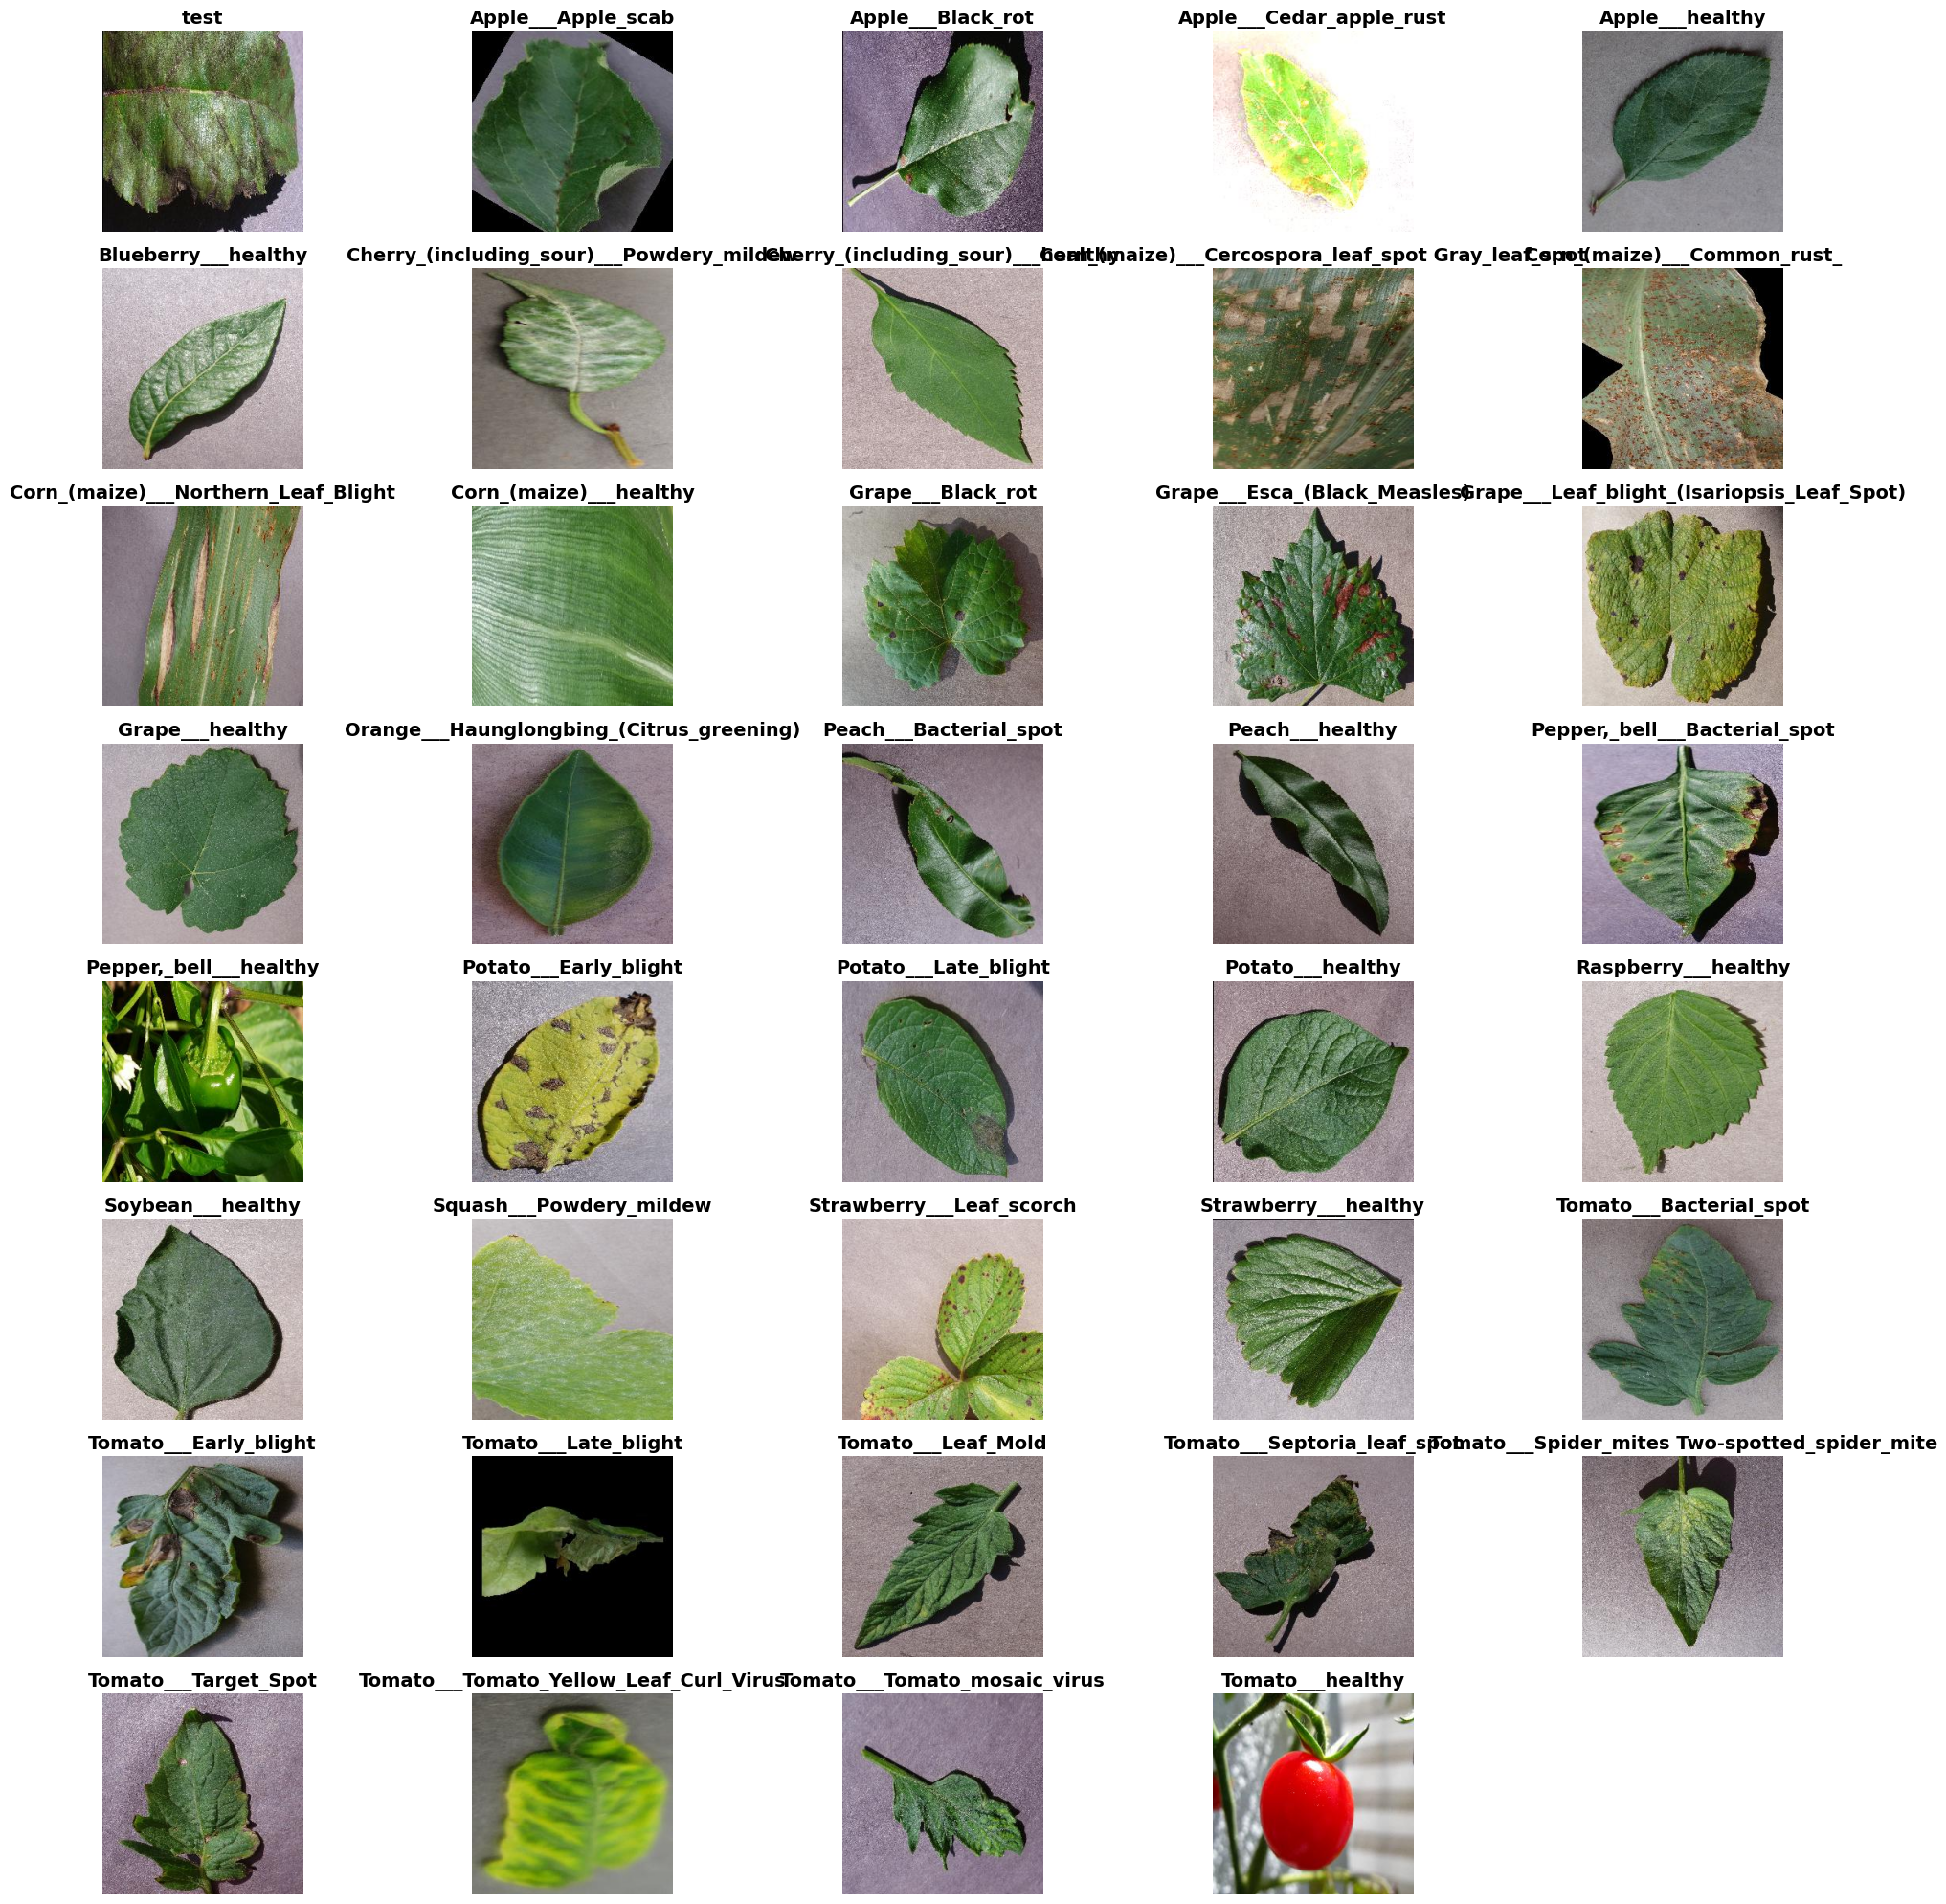

In [50]:
def show_all_examples(df: pd.DataFrame, figsize: tp.Tuple[int, int] = (20, 20)) -> None:
    """
    Display one example image per class in a single grid.
    """
    classes = df["class"].unique()
    n_classes = len(classes)
    n_cols = 5
    n_rows = math.ceil(n_classes / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for ax, class_name in zip(axes, classes):
        img_path = df[df["class"] == class_name]["path"].iloc[0]
        try:
            with Image.open(img_path) as img:
                ax.imshow(img)
                ax.set_title(class_name, fontsize=14, fontweight="bold")
                ax.axis("off")
        except Exception as e:
            print(f"Failed to open {img_path}: {e}")
            ax.axis("off")

    for ax in axes[n_classes:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


show_all_examples(df)

In [41]:
df['class'].value_counts(normalize=True)

class
Soybean___healthy                                     0.028749
Apple___Apple_scab                                    0.028669
Orange___Haunglongbing_(Citrus_greening)              0.028589
Apple___healthy                                       0.028555
Pepper,_bell___healthy                                0.028271
Apple___Black_rot                                     0.028259
Tomato___Tomato_Yellow_Leaf_Curl_Virus                0.027884
Potato___Late_blight                                  0.027577
Potato___Early_blight                                 0.027577
Tomato___healthy                                      0.027383
Grape___Esca_(Black_Measles)                          0.027304
Tomato___Early_blight                                 0.027304
Pepper,_bell___Bacterial_spot                         0.027201
Corn_(maize)___Northern_Leaf_Blight                   0.027133
Corn_(maize)___Common_rust_                           0.027122
Grape___Black_rot                                

In [51]:
print(f"Total number of classes is: {len(df['class'].unique()) - 1}")

Total number of classes is: 38


#### As one can see, the distribution of all the classes is uniform, which is good for us since there is no need for data rebalancing

In [53]:
def extract_image_size(row):
    """
    Returns (width, height) of image at row['path']
    """
    try:
        with Image.open(row["path"]) as img:
            return pd.Series([img.width, img.height])
    except Exception:
        return pd.Series([None, None])


df[["width", "height"]] = df.apply(extract_image_size, axis=1)

In [55]:
df['width'].value_counts()

width
256    87900
Name: count, dtype: int64

In [56]:
df['height'].value_counts()

height
256    87900
Name: count, dtype: int64

### All images have equal shape (256, 256)

In [59]:
def compute_rgb_stats(img_path: Path):
    try:
        with Image.open(img_path) as img:
            img = img.convert("RGB")
            arr = np.array(img)
            # compute mean/std per channel
            mean = arr.mean(axis=(0,1))
            std = arr.std(axis=(0,1))
            return pd.Series([mean[0], mean[1], mean[2], std[0], std[1], std[2]])
    except Exception:
        return pd.Series([np.nan]*6)

df[['R_mean','G_mean','B_mean','R_std','G_std','B_std']] = df['path'].apply(compute_rgb_stats)

print("Mean RGB values (dataset):")
print(df[['R_mean','G_mean','B_mean']].mean())

print("\nStandard deviation RGB values (dataset):")
print(df[['R_std','G_std','B_std']].mean())

Mean RGB values (dataset):
R_mean    121.316329
G_mean    127.540814
B_mean    108.723533
dtype: float64

Standard deviation RGB values (dataset):
R_std    47.112743
G_std    40.628300
B_std    51.644284
dtype: float64


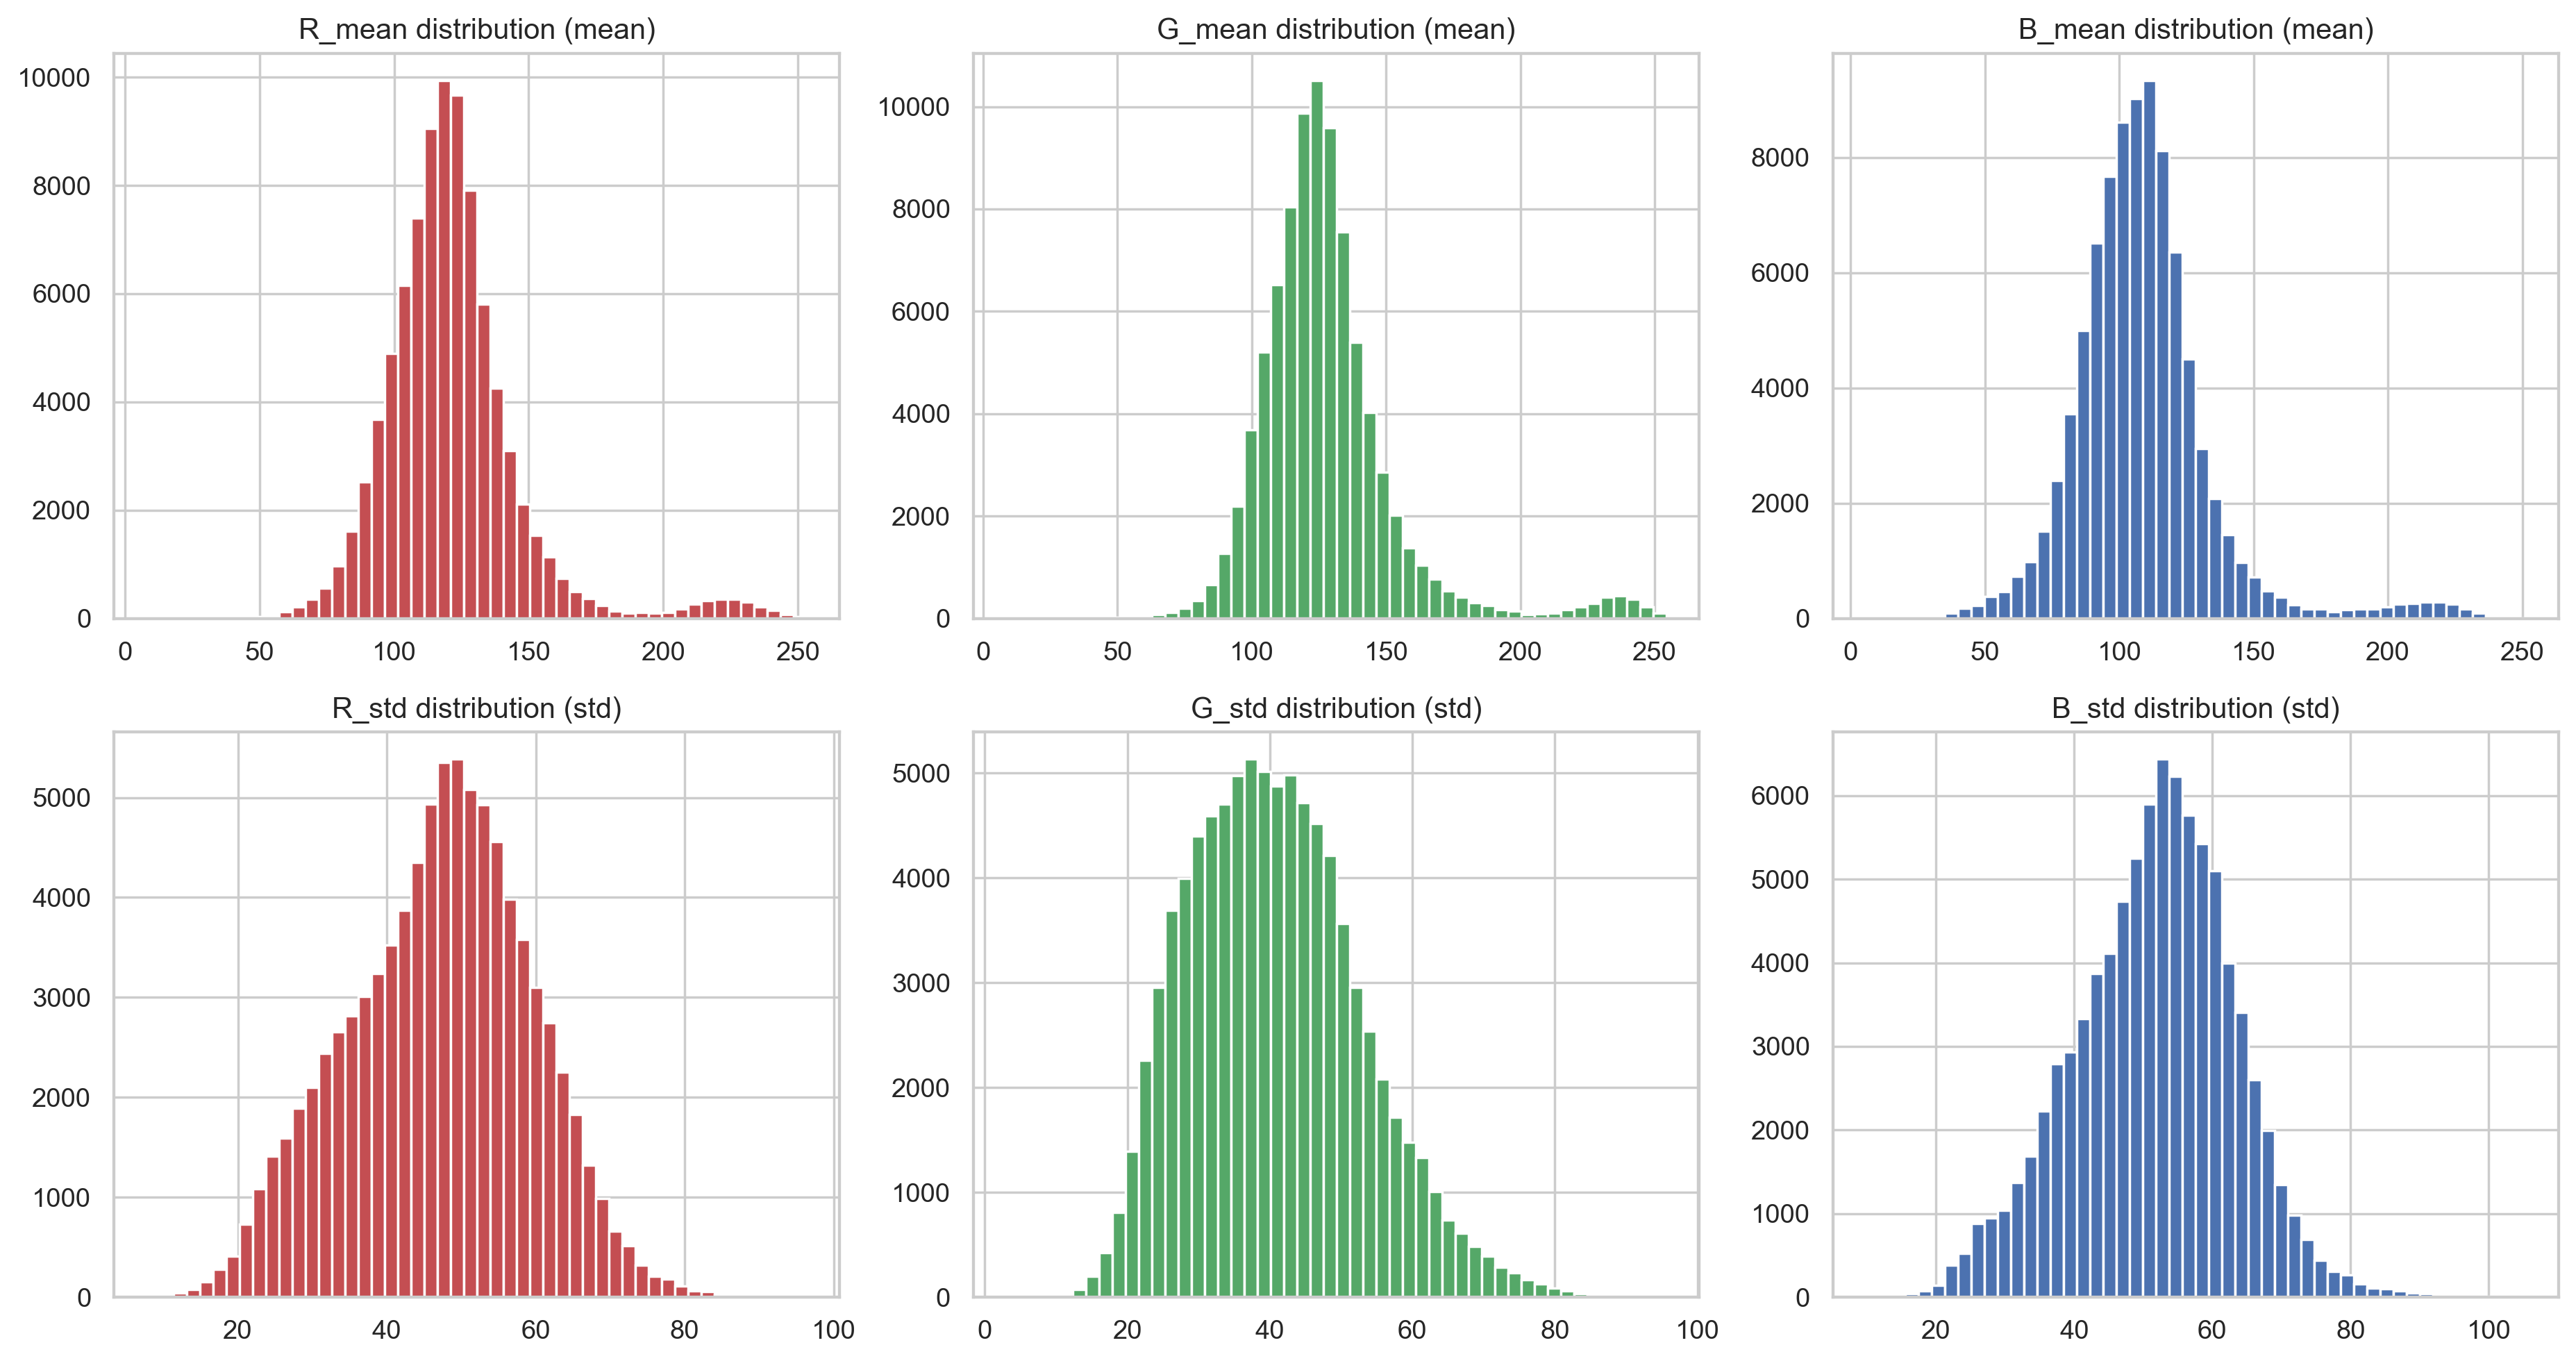

In [60]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8), dpi=250)
channels_mean = ['R_mean','G_mean','B_mean']
channels_std = ['R_std','G_std','B_std']

for i, ch in enumerate(channels_mean):
    axes[0,i].hist(df[ch].dropna(), bins=50, color=ch[0].lower())
    axes[0,i].set_title(f"{ch} distribution (mean)")
    
for i, ch in enumerate(channels_std):
    axes[1,i].hist(df[ch].dropna(), bins=50, color=ch[0].lower())
    axes[1,i].set_title(f"{ch} distribution (std)")

plt.tight_layout()
plt.show()

### From the plots we see that there are no outliers in terms of very dark or very light images

In [63]:
import imagehash
import itertools

def compute_hash(img_path: Path):
    try:
        with Image.open(img_path) as img:
            return imagehash.phash(img)
    except Exception:
        return None

df['hash'] = df['path'].apply(compute_hash)

Found 13 near-duplicate pairs across classes.


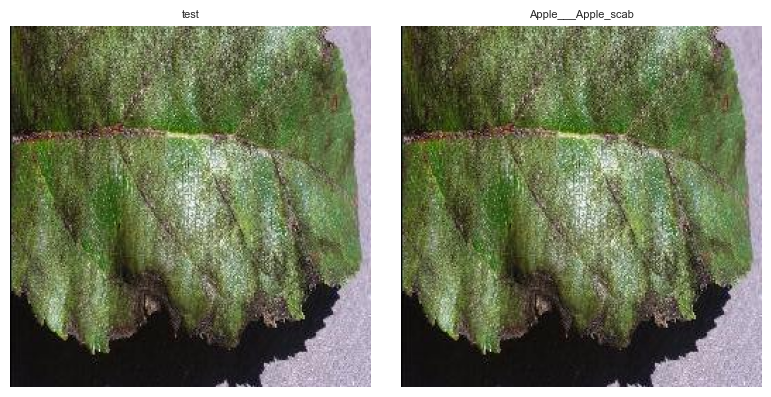

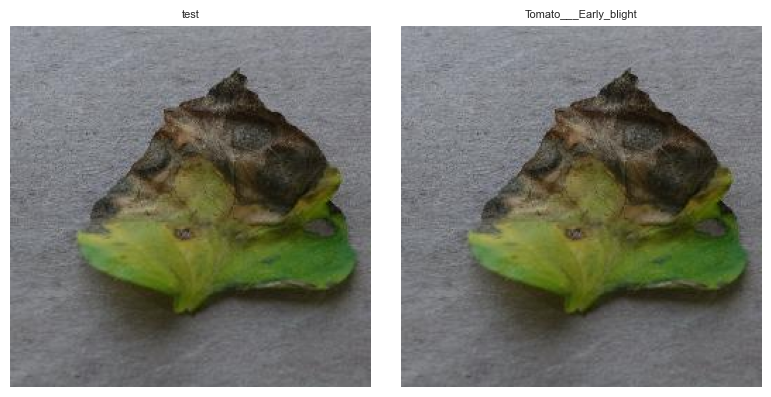

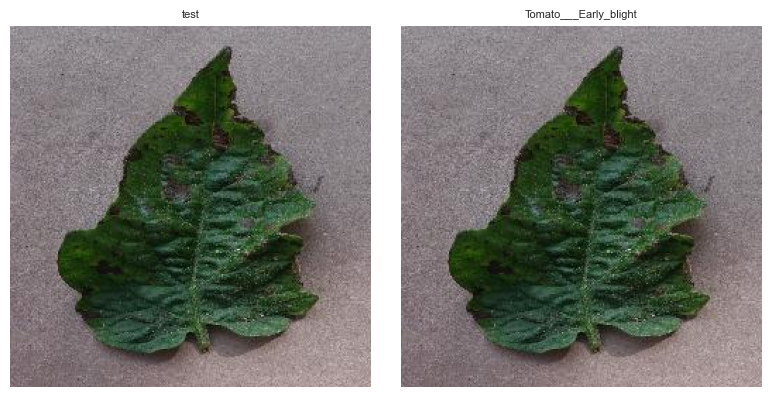

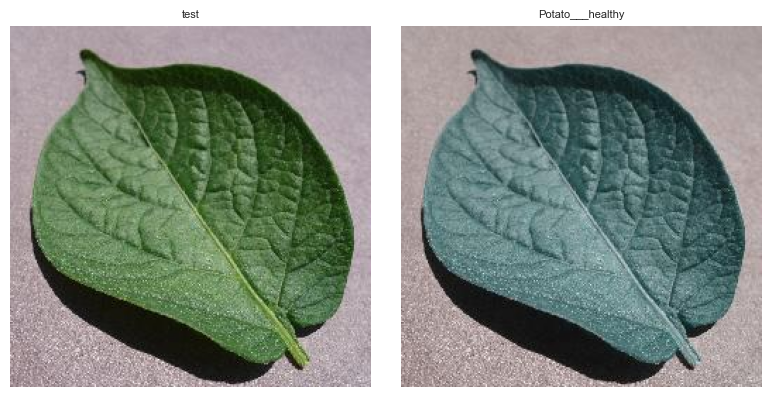

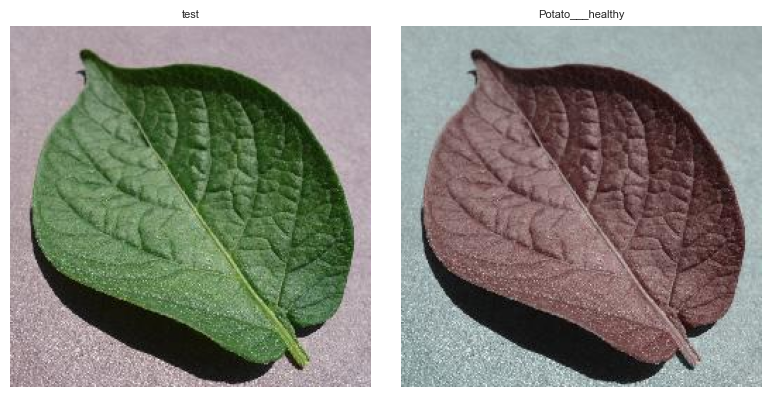

In [69]:
# let's consider hamming distance <= 5 as duplicate images 
threshold = 5
duplicates = []

hash_list = df[['hash','path','class']].dropna().to_dict('records')

for a, b in itertools.islice(itertools.combinations(hash_list, 2), 1000000):
    if a['class'] != b['class'] and (a['hash'] - b['hash']) <= threshold:
        duplicates.append((a['path'], b['path'], a['class'], b['class']))

print(f"Found {len(duplicates)} near-duplicate pairs across classes.")

def display_pair(img1_path, img2_path, class1, class2):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    for ax, img_path, cls in zip(axes, [img1_path, img2_path], [class1, class2]):
        with Image.open(img_path) as img:
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(cls, fontsize=8)
    plt.tight_layout()
    plt.show()

for dup in duplicates[:5]:
    display_pair(*dup)

### It seems like we just have found a data leakage. Images from the training/validation sets overlap with the test set. Further we will need to drop such cases from the test/train sets.